# Imports

In [1]:
#from src import Build_mc,Upload_geof,Upload_geof_geografica,Upload_litologia,plot_filtered_values,plot_raw_mag_data,plot_raw_gama_data,plot_histograms,plot_interpolated_histograms,describe_geologico, plotBoxplots,remove_negative_values,sintetic_grid,traditional_interpolation,plot_interpolated_histograms,pop_nodata
from src import *
from pylab import *

from tqdm import tqdm
from shapely.ops import transform
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import verde as vd
import numpy as np
import os
import pyproj
import verde_source as vds

import seaborn as sns
import xarray as xr
import matplotlib

from sklearn_som.som import SOM
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib widget
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
'''def sintetic_grider(quadricula=None,p_size=None):
    ids = list(quadricula.keys())
    wgs84=pyproj.CRS('EPSG:4326')
    for id in tqdm(ids):
        folha = quadricula[id]['folha']
        utm = pyproj.CRS('EPSG:'+folha['EPSG'])
        carta_geografica = folha['geometry']
        project = pyproj.Transformer.from_crs(wgs84,utm, always_xy=True).transform
        carta_utm = transform(project,carta_geografica)
        break
'''

"def sintetic_grider(quadricula=None,p_size=None):\n    ids = list(quadricula.keys())\n    wgs84=pyproj.CRS('EPSG:4326')\n    for id in tqdm(ids):\n        folha = quadricula[id]['folha']\n        utm = pyproj.CRS('EPSG:'+folha['EPSG'])\n        carta_geografica = folha['geometry']\n        project = pyproj.Transformer.from_crs(wgs84,utm, always_xy=True).transform\n        carta_utm = transform(project,carta_geografica)\n        break\n"

## Construindo Quadrícula

In [4]:
quadricula = Build_mc(escala='250k',ID=['SF23_YA','SF23_YB',
                                        'SF23_VC','SF23_VD'],verbose=True)

100%|███████████████████████████████████████| 4/4 [00:00<00:00, 560.96it/s]


 - Folhas selecionadas:


4it [00:00, 445.44it/s]

"SF23_YA"
"SF23_YB"
"SF23_VC"
"SF23_VD"

  4 folhas adicionadas.


In [5]:
list_ids = list(quadricula.keys())
#print(list_ids)

'''
for id in list_ids:
    print(f' - Folha: {id}')
    carta=quadricula[id]
    data_list = list(carta.keys())
    print(data_list)
    for data in data_list[4:]:
        print(f'    - {data}')
        print(f'        - {list(quadricula[id][data].columns)}')
'''    
def print_quadriculas(quadricula=quadricula):
    list_ids = list(quadricula.keys())
    for id in list_ids:
        print(f' - Folha {id}')
        carta = quadricula[id]
        list_carta_keys = list(carta.keys())
        print(f'    - {list_carta_keys}:')
        for key in list_carta_keys:
            print(carta[key])
            print('')

In [6]:
print_quadriculas(quadricula)

 - Folha SF23_YA
    - ['folha']:
EPSG                                                         32723
SIGLA                                                         None
geometry         POLYGON ((-48 -22, -46.5 -22, -46.5 -23, -48 -...
geometry_proj    POLYGON ((190234.94993116654 7564133.20832909,...
Name: SF23_YA, dtype: object

 - Folha SF23_YB
    - ['folha']:
EPSG                                                         32723
SIGLA                                                         None
geometry         POLYGON ((-46.5 -22, -45 -22, -45 -23, -46.5 -...
geometry_proj    POLYGON ((345155.92149832076 7566413.631237755...
Name: SF23_YB, dtype: object

 - Folha SF23_VC
    - ['folha']:
EPSG                                                         32723
SIGLA                                                         None
geometry         POLYGON ((-48 -21, -46.5 -21, -46.5 -22, -48 -...
geometry_proj    POLYGON ((188106.92493514047 7674924.30547923,...
Name: SF23_VC, dtype: object

 - F

### Construindo grid regular sintético

_Verde gridder_

In [7]:
from verde import grid_coordinates

In [8]:
def batch_grid_coordinates(quadricula,spacing=0.001,pixel_register=True):
    list_id = list(quadricula.keys())
    #print(f' Folhas disponíveis: {list_id}')
    for id in list_id:
        folha = quadricula[id]
        print(f' Folha  {id}')

        df = quadricula[id]['folha']
        area = (df['geometry'].bounds[0],df['geometry'].bounds[2],
                df['geometry'].bounds[1],df['geometry'].bounds[3])
        
        xu,yu = grid_coordinates(region=area,spacing=spacing,pixel_register=pixel_register)
       
        df['coords'] = xu,yu
        df['area'] = area
        x={'area':df}
        quadricula[id].update(x)
        

batch_grid_coordinates(quadricula)

 Folha  SF23_YA
 Folha  SF23_YB
 Folha  SF23_VC
 Folha  SF23_VD


In [9]:
print_quadriculas(quadricula)

 - Folha SF23_YA
    - ['folha', 'area']:
EPSG                                                         32723
SIGLA                                                         None
geometry         POLYGON ((-48 -22, -46.5 -22, -46.5 -23, -48 -...
geometry_proj    POLYGON ((190234.94993116654 7564133.20832909,...
coords           ([[-47.9995, -47.99850000000001, -47.9975, -47...
area                                  (-48.0, -46.5, -23.0, -22.0)
Name: SF23_YA, dtype: object

EPSG                                                         32723
SIGLA                                                         None
geometry         POLYGON ((-48 -22, -46.5 -22, -46.5 -23, -48 -...
geometry_proj    POLYGON ((190234.94993116654 7564133.20832909,...
coords           ([[-47.9995, -47.99850000000001, -47.9975, -47...
area                                  (-48.0, -46.5, -23.0, -22.0)
Name: SF23_YA, dtype: object

 - Folha SF23_YB
    - ['folha', 'area']:
EPSG                                                

In [10]:
quadricula['SF23_YA']['area']['coords']

(array([[-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005],
        [-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005],
        [-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005],
        ...,
        [-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005],
        [-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005],
        [-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005]]),
 array([[-22.9995, -22.9995, -22.9995, ..., -22.9995, -22.9995, -22.9995],
        [-22.9985, -22.9985, -22.9985, ..., -22.9985, -22.9985, -22.9985],
        [-22.9975, -22.9975, -22.9975, ..., -22.9975, -22.9975, -22.9975],
        ...,
        [-22.0025, -22.0025, -22.0025, ..., -22.0025, -22.0025, -22.0025],
        [-22.0015, -22.0015, -22.0015, ..., -22.0015, -22.0015, -22.0015],
        [-22.0005, -22.0005, -22.0005, ..., -22.0005, -22.0005, -22.0005]]))

In [11]:
quadricula['SF23_YA']['folha']['coords']

(array([[-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005],
        [-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005],
        [-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005],
        ...,
        [-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005],
        [-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005],
        [-47.9995, -47.9985, -47.9975, ..., -46.5025, -46.5015, -46.5005]]),
 array([[-22.9995, -22.9995, -22.9995, ..., -22.9995, -22.9995, -22.9995],
        [-22.9985, -22.9985, -22.9985, ..., -22.9985, -22.9985, -22.9985],
        [-22.9975, -22.9975, -22.9975, ..., -22.9975, -22.9975, -22.9975],
        ...,
        [-22.0025, -22.0025, -22.0025, ..., -22.0025, -22.0025, -22.0025],
        [-22.0015, -22.0015, -22.0015, ..., -22.0015, -22.0015, -22.0015],
        [-22.0005, -22.0005, -22.0005, ..., -22.0005, -22.0005, -22.0005]]))

## Adicionando dados brutos à Quadrícula

In [12]:
#Upload_geof(quadricula,'gama_line_1105','mag_line_1105',1000)
#gama_1039,mag_1039=Upload_geof(quadricula,'gama_1039','mag_1039',1000)

Upload_geof_geografica(quadricula,'gama_line_1105','mag_line_1105',0.01)

 25%|██████████                              | 1/4 [00:00<00:00,  9.67it/s]

 - gama_line_1105 atualizado na folha: SF23_YA com 42009 pontos
 - mag_line_1105 atualizado na folha: SF23_YA com 436906 pontos
 - gama_line_1105 atualizado na folha: SF23_YB com 448632 pontos


100%|████████████████████████████████████████| 4/4 [00:00<00:00,  8.63it/s]

 - mag_line_1105 atualizado na folha: SF23_YB com 4576712 pontos
 - gama_line_1105 atualizado na folha: SF23_VC com 58640 pontos
 - mag_line_1105 atualizado na folha: SF23_VC com 590361 pontos
 - mag_line_1105 atualizado na folha: SF23_VD com 84337 pontos


In [13]:
quadricula['SF23_YA']['gama_line_1105'].head()

,X,Y,LATITUDE,LONGITUDE,CTCOR,eU,eTh,KPERC,UTHRAZAO,THKRAZAO,UKRAZAO,MDT
19061,316870.31,7567198.83,-21.990175,-46.773827,49.2,2.30,37.10,3.33,0.1,10.00,0.6,797.04
19062,316872.05,7567122.81,-21.990862,-46.773818,45.8,1.96,35.34,3.52,0.1,10.18,0.6,806.81
19063,316873.96,7567046.97,-21.991547,-46.773808,36.7,1.77,27.30,3.06,0.1,10.39,0.6,819.98
19064,316875.53,7566971.13,-21.992232,-46.773802,28.6,1.29,21.60,2.12,0.1,10.63,0.7,836.34
19065,316876.92,7566895.66,-21.992913,-46.773797,23.9,1.00,17.50,1.48,0.1,10.93,0.7,841.73


In [14]:
geof_list_ids = list(quadricula.keys())
for id in geof_list_ids:
    print(f' - Folha: {id}')
    carta=quadricula[id]
    data_list = list(carta.keys())
    print(data_list)
    for data in data_list[4:]:
        print(f'    - {data}')
        print(f'        - {list(quadricula[id][data].columns)}')
    print('')


 - Folha: SF23_YA
['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha: SF23_YB
['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha: SF23_VC
['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha: SF23_VD
['folha', 'area', 'mag_line_1105']



In [15]:
quadricula=pop_nodata(quadricula)
len(quadricula.keys())

for id in list(quadricula.keys()):
    print(f' - Folha:  {id}')
    carta = quadricula[id]
    print(f'    - {list(carta.keys())}')
    print('')

100%|████████████████████████████████████| 4/4 [00:00<00:00, 115704.94it/s]

 - Folha:  SF23_YA
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_YB
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_VC
    - ['folha', 'area', 'gama_line_1105', 'mag_line_1105']

 - Folha:  SF23_VD
    - ['folha', 'area', 'mag_line_1105']



## Vizualisando Área de Cobertura

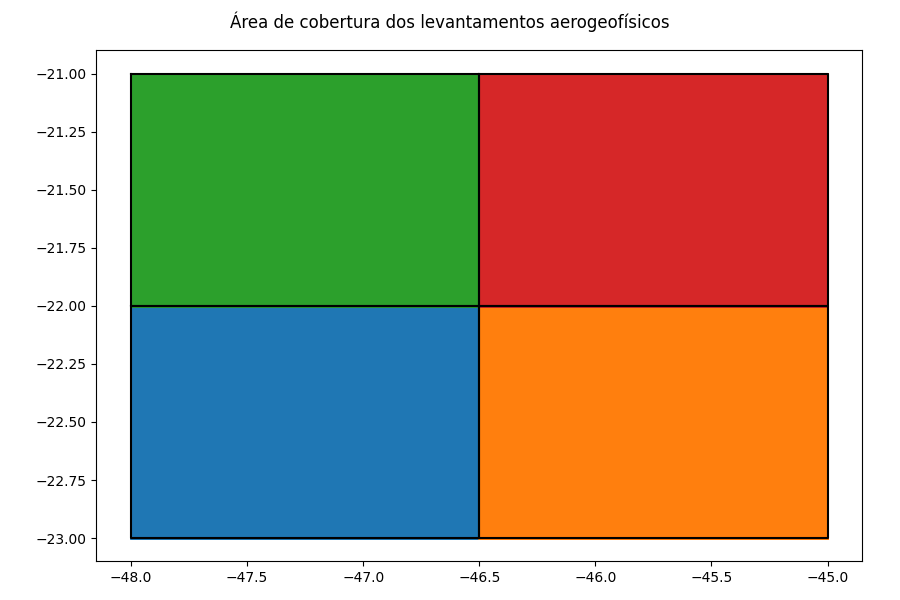

In [16]:
plt.figure(figsize=(9,6))
for id in list(quadricula.keys()):
    carta=quadricula[id]['area']
    plt.plot(*(carta['geometry']).exterior.xy,color='black')
    plt.axis('scaled')
    plt.scatter(carta['coords'][0],carta['coords'][1],s=1)    
plt.suptitle('Área de cobertura dos levantamentos aerogeofísicos')
plt.axis('scaled')
plt.tight_layout()

In [17]:
list(carta.keys())

['EPSG', 'SIGLA', 'geometry', 'geometry_proj', 'coords', 'area']

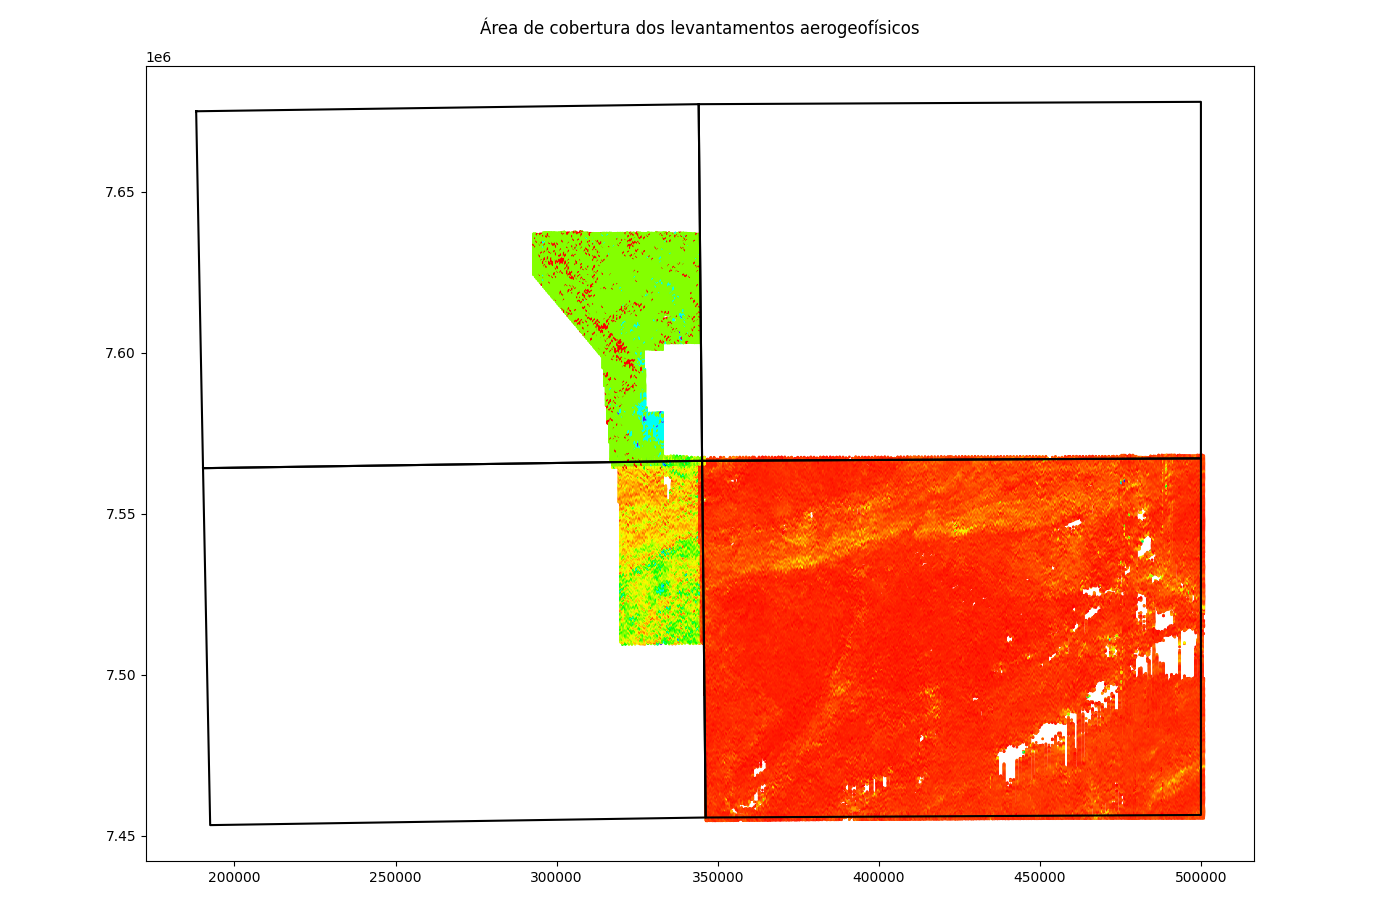

In [18]:
plt.figure(figsize=(14,9))
for id in list(quadricula.keys()):
    carta=quadricula[id]
    #print(carta.keys())
    plt.plot(*(carta['area']['geometry_proj']).exterior.xy,color='black')
    plt.axis('scaled')
    for data in list(carta.keys())[:]:
        if 'gama' in data:
            #print(data)
            plt.scatter(carta[data].X,carta[data].Y,c=carta[data].UTHRAZAO,cmap='hsv',s=1,marker='H')    
        else:
            None
plt.suptitle('Área de cobertura dos levantamentos aerogeofísicos')
plt.axis('scaled')
plt.tight_layout()

#### Visualizando dados Radiométricos Brutos

In [19]:
df = quadricula['SF23_YA']['gama_line_1105']
#remove_negative_values()

Levantamento Novo


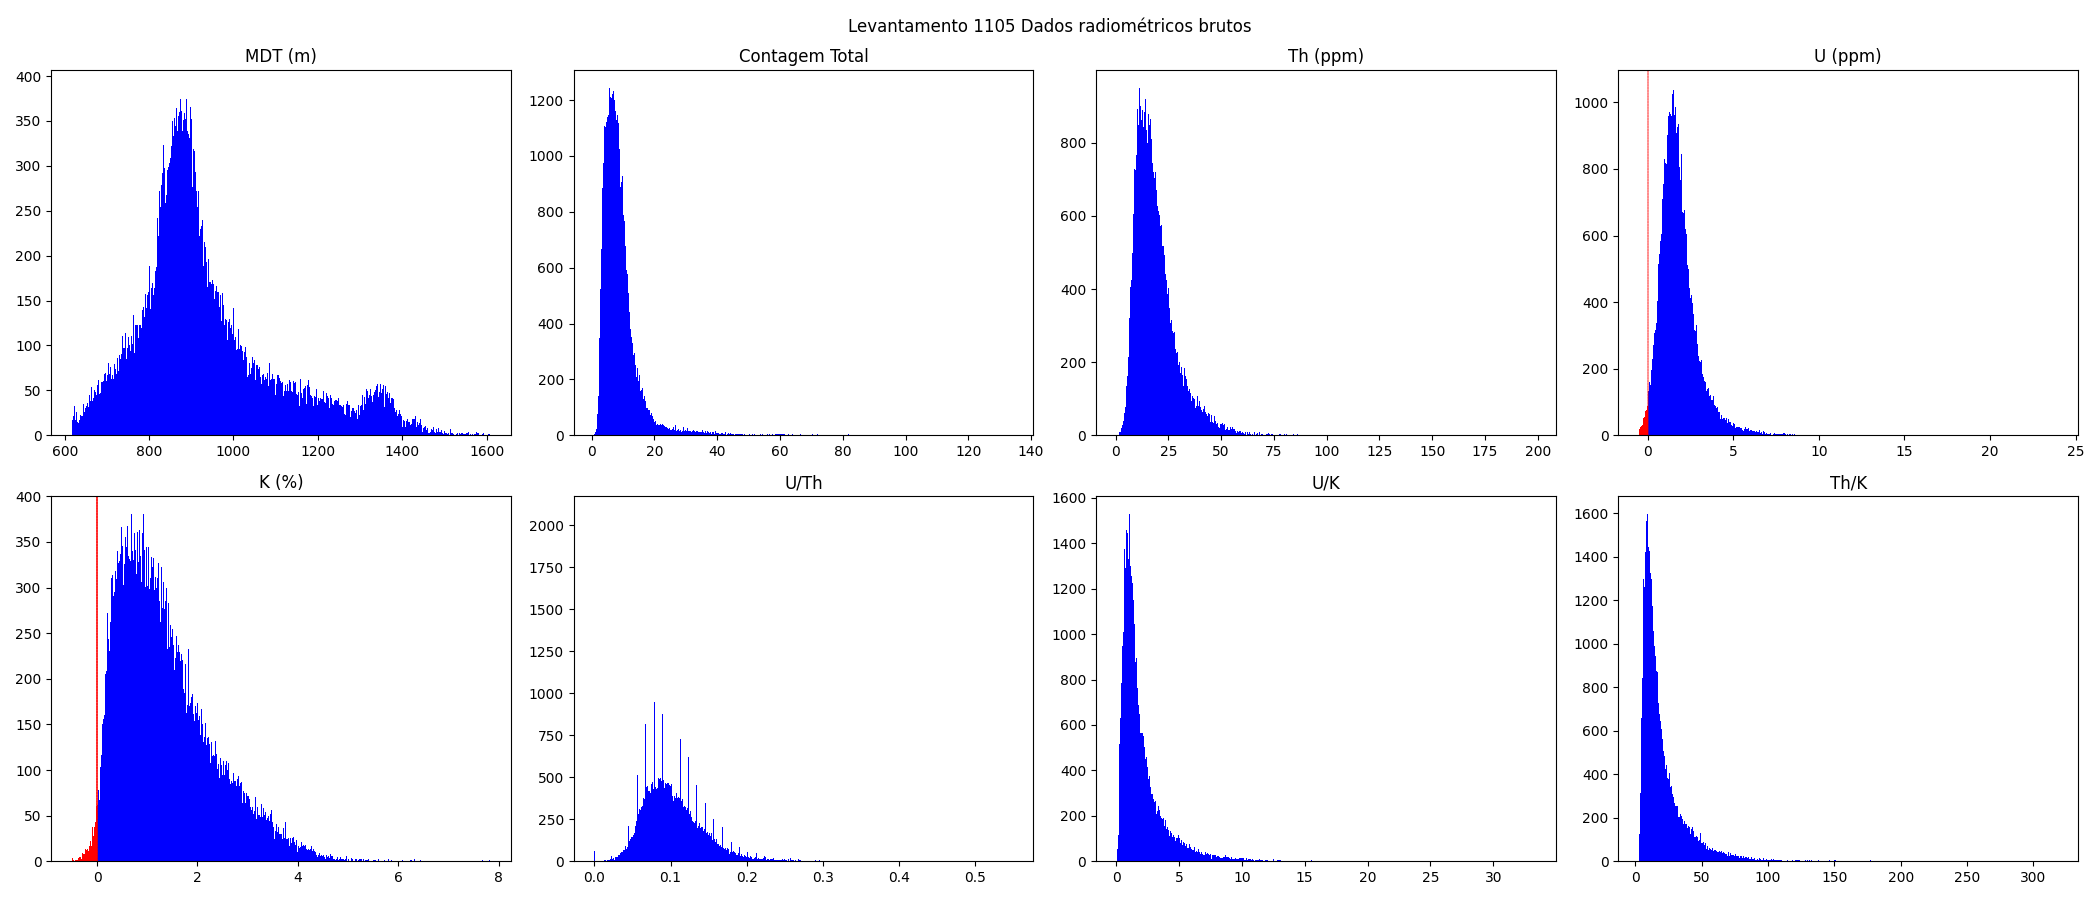

In [20]:
plot_histograms(df,500,'Levantamento 1105 Dados radiométricos brutos')

# Interpolação dos dados Brutos

## Verde Splines

## Método Linear

In [21]:
list(quadricula['SF23_YA']['area'].keys())

['EPSG', 'SIGLA', 'geometry', 'geometry_proj', 'coords', 'area']

In [22]:
quadricula['SF23_YA']['area']['area']

(-48.0, -46.5, -23.0, -22.0)

In [23]:
traditional_interpolation(quadricula,'mag_line_1105','gama_line_1105','linear','geof_1105',extrapolate=False,projec='geog')
#traditional_interpolation(quadricula,'mag_1039','gama_1039','linear','geof_1039',extrapolate=True)
#traditional_interpolation(quadricula,'mag_3022','gama_3022','linear','geof_3022')

  0%|                                                | 0/4 [00:00<?, ?it/s]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std      min         1%      25%  \
CTCOR     42009.0    9.210207    6.975640    0.916    2.45308    5.425   
eU        42009.0    1.833200    1.175079   -0.488   -0.03300    1.110   
eTh       42009.0   19.086223   10.390289    0.557    5.28356   11.934   
KPERC     42009.0    1.373024    0.948267   -0.499    0.00008    0.651   
UTHRAZAO  42009.0    0.103415    0.039516    0.000    0.03300    0.076   
THKRAZAO  42009.0   20.649393   19.027709    2.830    4.06716    9.278   
UKRAZAO   42009.0    2.052902    1.912181    0.061    0.25000    0.900   
MDT       42009.0  939.953437  171.981530  617.280  652.81240  834.150   

              50%       75%        90%        99.9%       max  
CTCOR       7.736    10.630    14.9092    75.491200   134.100  
eU          1.635     2.294     3.1642     9.189760    23.934  
eTh 

 25%|██████████                              | 1/4 [00:14<00:42, 14.31s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
             count         mean         std      min       1%      25%  \
CTCOR     448632.0     9.356740    6.230493   -2.947    2.341    5.544   
eU        448632.0     1.650916    0.928488   -0.500   -0.111    1.009   
eTh       448632.0    19.213771    9.163465   -3.080    4.849   12.587   
KPERC     448632.0     0.823944    0.636448   -0.499   -0.095    0.383   
UTHRAZAO  448632.0     0.093937    0.044436    0.005    0.029    0.065   
THKRAZAO  448632.0    34.771692   30.569288    1.079    5.147   15.873   
UKRAZAO   448632.0     3.023197    2.660053    0.046    0.338    1.341   
MDT       448632.0  1059.082722  302.753659  513.280  529.850  874.820   

               50%         75%        90%        99.9%       max  
CTCOR       7.6805    10.72500    16.7440    45.975904    85.820  
eU          1.5590     2.18400     2.8360     6.126000    20.8

 50%|████████████████████                    | 2/4 [02:53<03:18, 99.28s/it]

Atributo - CTCOR
Atributo - eU
Atributo - eTh
Atributo - KPERC
Atributo - UTHRAZAO
Atributo - THKRAZAO
Atributo - UKRAZAO
Atributo - MDT
            count        mean         std      min        1%     25%     50%  \
CTCOR     58640.0   25.206753   15.484063    0.600    7.7000   16.40   21.70   
eU        58640.0    1.485607    1.448021   -0.480    0.0600    0.74    1.13   
eTh       58640.0   16.099713    9.955715    0.030    4.0100   10.07   13.74   
KPERC     58640.0    1.298366    0.855271   -0.420    0.1100    0.65    1.12   
UTHRAZAO  58640.0    0.097016    0.033261    0.000    0.0000    0.10    0.10   
THKRAZAO  58640.0   14.600808    8.047209    3.040    6.0000    9.56   12.42   
UKRAZAO   58640.0    1.385370    1.066847    0.061    0.2000    0.70    1.10   
MDT       58640.0  965.667562  199.784612  571.000  624.3529  814.23  911.40   

              75%       90%        99.9%       max  
CTCOR       28.90    39.800   143.300000   246.600  
eU           1.67     2.680    13.39

100%|████████████████████████████████████████| 4/4 [03:12<00:00, 48.18s/it]


In [45]:
ds_a = quadricula['SF23_YA']['geof_1105_linear']
ds_b = quadricula['SF23_YB']['geof_1105_linear']
ds_c = quadricula['SF23_VC']['geof_1105_linear']
#ds_d = quadricula['SF23_VD']['geof_1105_linear']

KeyError: 'geof_1105_linear'

In [46]:
ds_c

<xarray.Dataset>
Dimensions:    (LATITUDE: 1000, LONGITUDE: 1500)
Coordinates:
  * LATITUDE   (LATITUDE) float64 -22.0 -22.0 -22.0 -22.0 ... -21.0 -21.0 -21.0
  * LONGITUDE  (LONGITUDE) float64 -48.0 -48.0 -48.0 -48.0 ... -46.5 -46.5 -46.5
Data variables:
    MDT        (LATITUDE, LONGITUDE) float64 nan nan nan nan ... nan nan nan nan
    CTCOR      (LATITUDE, LONGITUDE) float64 nan nan nan nan ... nan nan nan nan
    KPERC      (LATITUDE, LONGITUDE) float64 nan nan nan nan ... nan nan nan nan
    eU         (LATITUDE, LONGITUDE) float64 nan nan nan nan ... nan nan nan nan
    eTh        (LATITUDE, LONGITUDE) float64 nan nan nan nan ... nan nan nan nan
    GMT        (LATITUDE, LONGITUDE) float64 nan nan nan nan ... nan nan nan nan
    UTHRAZAO   (LATITUDE, LONGITUDE) float64 nan nan nan nan ... nan nan nan nan
    UKRAZAO    (LATITUDE, LONGITUDE) float64 nan nan nan nan ... nan nan nan nan
    THKRAZAO   (LATITUDE, LONGITUDE) float64 nan nan nan nan ... nan nan nan nan

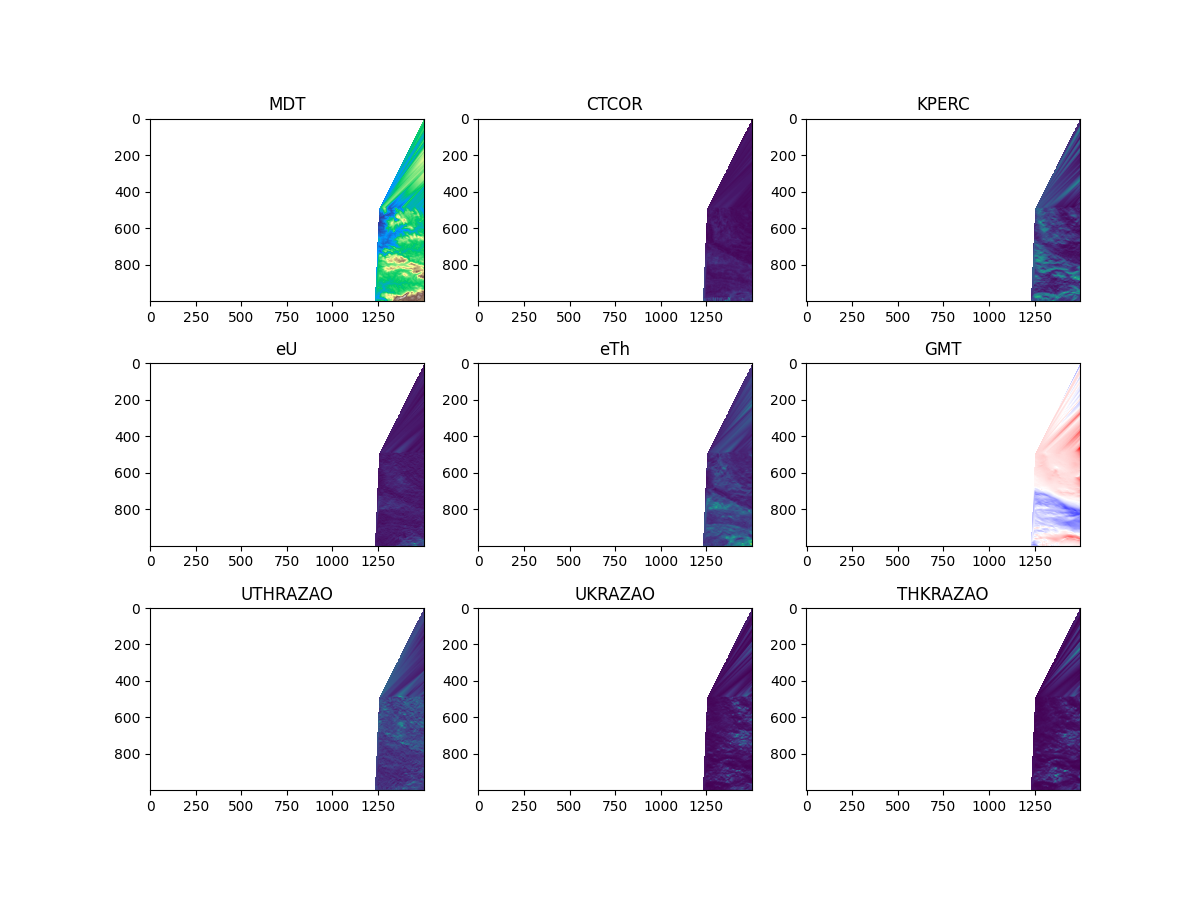

In [47]:
fig, axes = plt.subplots(3,3,figsize=(12,9))
list_data = list(ds_c.keys())
for i,ax in enumerate(axes.flatten()):
    
    if i < len(list_data):
        if list_data[i] == 'GMT':
            ax.imshow(ds_a[list_data[i]],cmap='bwr')
            ax.set(title=ds_a[list_data[i]].name)
        elif list_data[i]=='MDT':
            ax.imshow(ds_a[list_data[i]],cmap='terrain')
            ax.set(title=ds_a[list_data[i]].name)
        
        else:
            ax.imshow(ds_a[list_data[i]])
            ax.set(title=ds_a[list_data[i]].name)

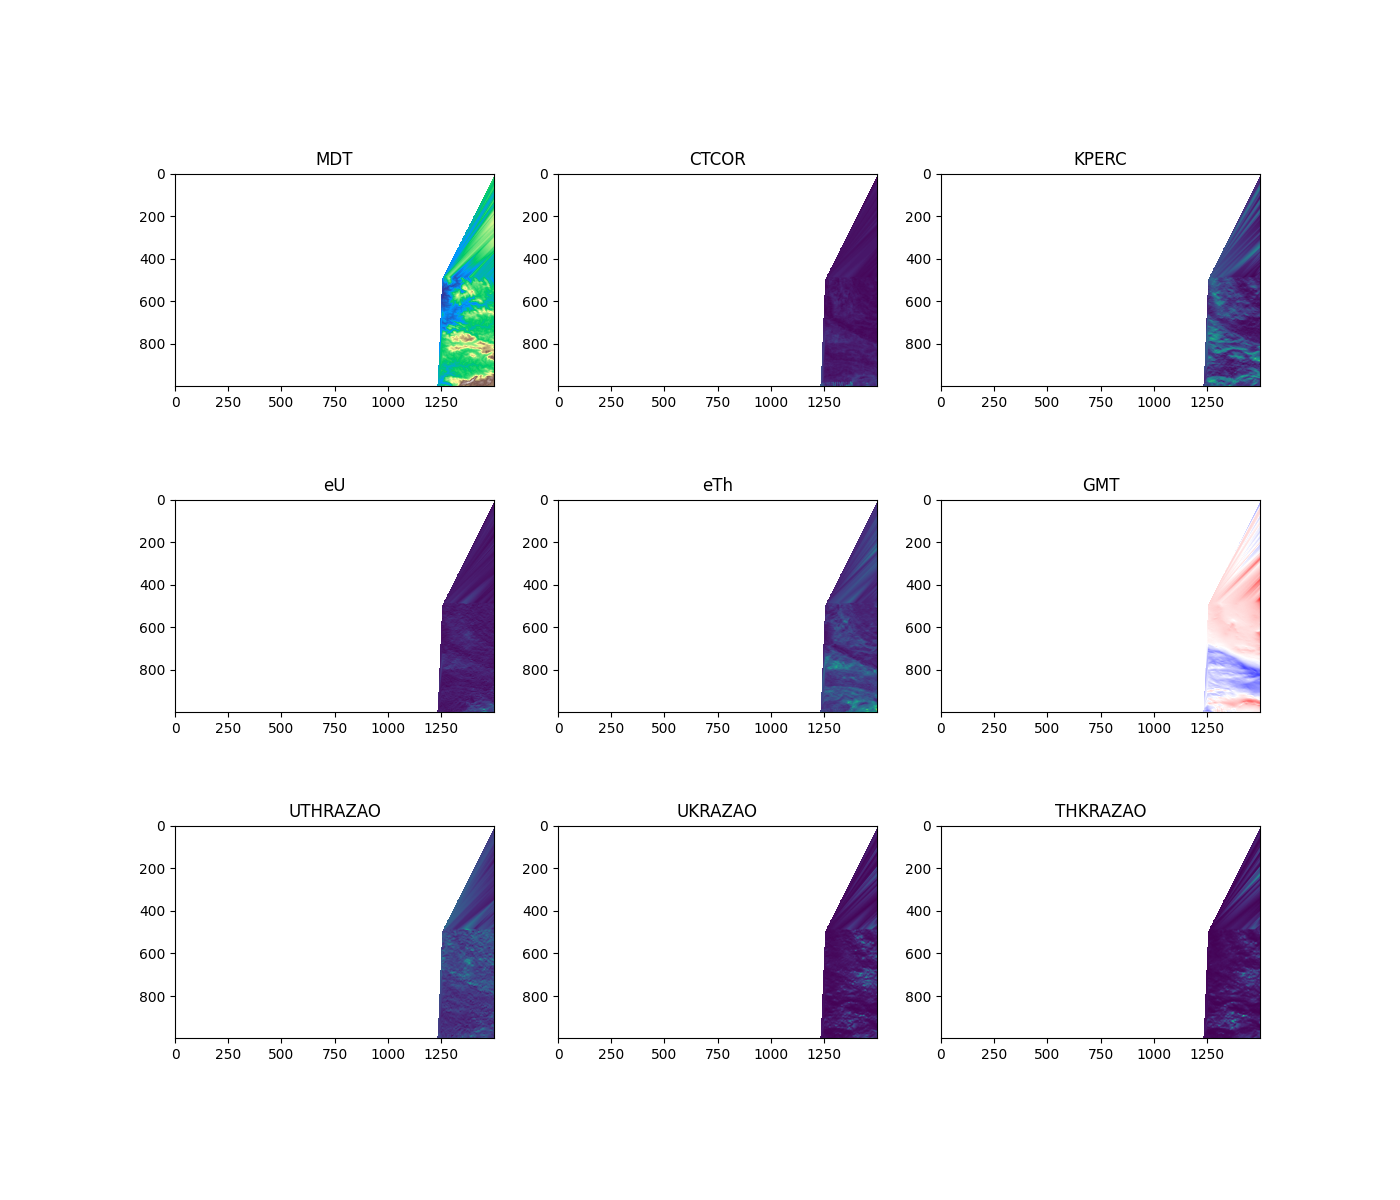

In [34]:
fig, axes = plt.subplots(3,3,figsize=(14,12))
list_data = list(ds_a.keys())
for i,ax in enumerate(axes.flatten()):
    
    if i < len(list_data):
        if list_data[i] == 'GMT':
            ax.imshow(ds_a[list_data[i]],cmap='bwr')
            ax.set(title=ds_a[list_data[i]].name)
        elif list_data[i]=='MDT':
            ax.imshow(ds_a[list_data[i]],cmap='terrain')
            ax.set(title=ds_a[list_data[i]].name)
        
        else:
            ax.imshow(ds_a[list_data[i]])
            ax.set(title=ds_a[list_data[i]].name)

# Classificações Não-Supervisionadas

## Rotulando amostras com classes litológicas

In [27]:
'''
import shapely.speedups
from shapely import geometry
shapely.speedups.enable()

#geof_1089_linear['geometry'] = [geometry.Point(x,y) for x, y in zip(geof_1089_linear['X'], geof_1089_linear['Y'])]
#gdf_1089_linear = geof_1089_linear.set_geometry('geometry')

#gdf_1089_linear.set_crs('EPSG:32723',inplace=True)
#gdf_1089_linear.geometry

#Upload_litologia(quadricula,'litologia_100k')

litologia=quadricula['SB24_ZB_II']['litologia_100k']
litologia.to_crs('EPSG:32724',inplace=True)
print(litologia.crs)
litologia.reset_index(drop=True,inplace=True)

dic_litologico = describe_geologico(litologia)
print(litologia.columns)

#print(dic_litologico['SIGLA']['len'])
#print(dic_litologico['SIGLA']['lista'])

#litologia.plot('SIGLA',figsize=(16,16),legend=True)

#geof_1089_linear['closest_unit'] = geof_1089_linear['geometry'].apply(lambda x: litologia['SIGLA'].iloc[litologia.distance(x).idxmin()]) # .idxmin() Retorna o indice do menor valor 

#geof_1089_linear.to_csv('/home/ggrl/database/csv/SB24_ZB_II_gama_linear_100m.csv',index=False)
'''

"\nimport shapely.speedups\nfrom shapely import geometry\nshapely.speedups.enable()\n\n#geof_1089_linear['geometry'] = [geometry.Point(x,y) for x, y in zip(geof_1089_linear['X'], geof_1089_linear['Y'])]\n#gdf_1089_linear = geof_1089_linear.set_geometry('geometry')\n\n#gdf_1089_linear.set_crs('EPSG:32723',inplace=True)\n#gdf_1089_linear.geometry\n\n#Upload_litologia(quadricula,'litologia_100k')\n\nlitologia=quadricula['SB24_ZB_II']['litologia_100k']\nlitologia.to_crs('EPSG:32724',inplace=True)\nprint(litologia.crs)\nlitologia.reset_index(drop=True,inplace=True)\n\ndic_litologico = describe_geologico(litologia)\nprint(litologia.columns)\n\n#print(dic_litologico['SIGLA']['len'])\n#print(dic_litologico['SIGLA']['lista'])\n\n#litologia.plot('SIGLA',figsize=(16,16),legend=True)\n\n#geof_1089_linear['closest_unit'] = geof_1089_linear['geometry'].apply(lambda x: litologia['SIGLA'].iloc[litologia.distance(x).idxmin()]) # .idxmin() Retorna o indice do menor valor \n\n#geof_1089_linear.to_csv('/h

## Self-organizing maps (SOM)

### Pixel size

In [28]:
print(list(quadricula.keys()))
print('')
print(quadricula['SF23_YA_III4'].keys())
print('')
ds_a = quadricula['SF23_YA_III4']['geof_1105_linear']
ds_b = quadricula['SF23_YA_III2']['geof_1105_linear']

['SF23_YA', 'SF23_YB', 'SF23_VC', 'SF23_VD']



KeyError: 'SF23_YA_III4'

In [ ]:
ds_b.LONGITUDE.values.max()

In [ ]:
ds_a.LONGITUDE.values.max()

In [ ]:
ds_b

In [ ]:
ds_b['LATITUDE']

In [ ]:
ds_a['LATITUDE']

In [ ]:
ds = xr.combine_by_coords([ds_a,ds_b])

In [ ]:
#for id in tqdm(list(quadricula.keys())):
#    ds = quadricula[id]['geof_1105_linear']
features = list(ds.keys())
print(features)

In [ ]:
df = ds[features].to_dataframe()
df = df.reset_index()
df

In [ ]:
xpixel_size = (ds.LONGITUDE.max().values-ds.LONGITUDE.min().values)/ds.LONGITUDE.size
ypixel_size = (ds.LATITUDE.max().values-ds.LATITUDE.min().values)/ds.LATITUDE.size
print('x:', xpixel_size, 'y:', ypixel_size)

In [ ]:
nx = ds.LATITUDE.size
ny = ds.LONGITUDE.size

print(ny,nx,ny/nx)

xs = df.LONGITUDE.values.reshape(nx,ny)
ys = df.LATITUDE.values.reshape(nx,ny)

In [ ]:
def plot_corr(dataframe, size=10):
    plt.figure(figsize = (size+size*0.2, size), facecolor='w')
    corrMatrix = dataframe.corr()
    sns.heatmap(np.round(corrMatrix,2), annot=True,vmin=-1,vmax=1,cmap='bwr',center=0)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0, ha='right')

plot_corr(df, size=12)
#plt.savefig('figs/correlation_matrix.png', dpi=400, bbox_inches='tight')

In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(df[features].values)
data.shape

In [ ]:
n_clusters=7
lito_SOM = SOM(m=n_clusters, n=1, sigma=1.5, dim=len(features), max_iter=1000)
lito_SOM.fit(data)

In [ ]:
# predição de classes
predictions = lito_SOM.predict(data)

In [ ]:
# create labels
cluster_labels=[]
for i in range(n_clusters):
    cluster_labels+=[f'Classe {i+1}']

In [ ]:
# classes weights
fig, ax = plt.subplots(figsize=(19,19))
im=ax.matshow(lito_SOM.weights,cmap='bwr',vmin=-1.5,vmax=1.5)
for (i, j), z in np.ndenumerate(lito_SOM.weights):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.yticks(range(n_clusters), cluster_labels, fontsize=9)
plt.xticks(range(len(features)), features, rotation=55, fontsize=10, ha='left')
fig.colorbar(im, label='weights', orientation='horizontal')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10, 10)
plt.show()

In [ ]:

id_ = [1,2,3,4,6,7]
relcolor =  matplotlib.cm.Set3
colors = np.array(relcolor.colors)[id_]
relcolor = matplotlib.colors.ListedColormap(colors)

In [ ]:
idxs=np.arange(0, n_clusters, 1)
half=(idxs[1]-idxs[0])/2
ticks=np.linspace(idxs[0]+half, idxs[-1]-half, n_clusters)

In [ ]:
print(xs.shape,ys.shape)

In [ ]:
fig, ax=plt.subplots(figsize=(16, 16), facecolor='w')
im=plt.pcolormesh(xs, ys, predictions.reshape(ny, nx), cmap=relcolor, shading='auto')
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels, fontsize=8)
plt.suptitle('SOM - Aerogeophysical Data (SF23_YB_I)')
plt.axis('scaled')
plt.show()

In [ ]:
features = ['MDT','GMT','F_factor']

scaler = StandardScaler()
data = scaler.fit_transform(df[features].values)
n_clusters=10
lito_SOM = SOM(m=n_clusters, n=1, sigma=1.5, dim=len(features), max_iter=10000)
lito_SOM.fit(data)
# predição de classes
predictions = lito_SOM.predict(data)
# create labels
cluster_labels=[]
for i in range(n_clusters):
    cluster_labels+=[f'Classe {i+1}']


# classes weights
fig, ax = plt.subplots(figsize=(19,19))
im=ax.matshow(lito_SOM.weights)
for (i, j), z in np.ndenumerate(lito_SOM.weights):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.yticks(range(n_clusters), cluster_labels, fontsize=9)
plt.xticks(range(len(features)), features, rotation=55, fontsize=10, ha='left')
fig.colorbar(im, label='weights', orientation='horizontal')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10, 10)
plt.show()
import matplotlib
id_ = [1,2,3,4,5,6,7,8,9,10]
relcolor =  matplotlib.cm.Set3
colors = np.array(relcolor.colors)[id_]
relcolor = matplotlib.colors.ListedColormap(colors)
idxs=np.arange(0, n_clusters, 1)
half=(idxs[1]-idxs[0])/2
ticks=np.linspace(idxs[0]+half, idxs[-1]-half, n_clusters)
fig, ax=plt.subplots(figsize=(16, 16), facecolor='w')
im=plt.pcolormesh(xs, ys, predictions.reshape(ny, nx), cmap=relcolor, shading='auto')
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels, fontsize=8)
plt.suptitle('SOM - Aerogeophysical Data ( Aguas de Lindóia - SF23_YA_III4)')
plt.axis('scaled')
plt.show()

In [ ]:
features = ['MDT','GMT','F_factor','CTCOR']

scaler = StandardScaler()
data = scaler.fit_transform(df[features].values)
n_clusters=10
lito_SOM = SOM(m=n_clusters, n=1, sigma=1.5, dim=len(features), max_iter=10000)
lito_SOM.fit(data)
# predição de classes
predictions = lito_SOM.predict(data)
# create labels
cluster_labels=[]
for i in range(n_clusters):
    cluster_labels+=[f'Classe {i+1}']


# classes weights
fig, ax = plt.subplots(figsize=(19,19))
im=ax.matshow(lito_SOM.weights)
for (i, j), z in np.ndenumerate(lito_SOM.weights):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.yticks(range(n_clusters), cluster_labels, fontsize=9)
plt.xticks(range(len(features)), features, rotation=55, fontsize=10, ha='left')
fig.colorbar(im, label='weights', orientation='horizontal')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10, 10)
plt.show()
import matplotlib
id_ = [1,2,3,4,5,6,7,8,9,10]
relcolor =  matplotlib.cm.Set3
colors = np.array(relcolor.colors)[id_]
relcolor = matplotlib.colors.ListedColormap(colors)
idxs=np.arange(0, n_clusters, 1)
half=(idxs[1]-idxs[0])/2
ticks=np.linspace(idxs[0]+half, idxs[-1]-half, n_clusters)
fig, ax=plt.subplots(figsize=(16, 16), facecolor='w')
im=plt.pcolormesh(xs, ys, predictions.reshape(ny, nx), cmap=relcolor, shading='auto')
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels, fontsize=8)
plt.suptitle('SOM - Aerogeophysical Data ( Aguas de Lindóia - SF23_YA_III4)')
plt.axis('scaled')
plt.show()

In [ ]:
# get attributes
features = list(SF23_YA_III_4.keys())
print(features)
# transform a xarray.Dataset into pandas.Dataframe
df = SF23_YA_III_4[features].to_dataframe()
df = df.reset_index()

In [ ]:
# visualize correlations
plot_corr(df, size=12)
# SELECT FEATURES
features = ['MDT','GMT','F_factor']
print(f' - Selected Features: {features}')

In [ ]:
# get pixel size
xpixel_size = (ds.LONGITUDE.max().values-ds.LONGITUDE.min().values)/ds.LONGITUDE.size
ypixel_size = (ds.LATITUDE.max().values-ds.LATITUDE.min().values)/ds.LATITUDE.size
print('x:', xpixel_size, 'y:', ypixel_size)
# get number of pixels
nx = ds.LATITUDE.size
ny = ds.LONGITUDE.size
print(f'x:{ny} ; y:{nx} | x/y: {ny/nx}')
# reshape numpy.array into tuple of arrays
xs = df.LONGITUDE.values.reshape(nx,ny)
ys = df.LATITUDE.values.reshape(nx,ny)
# transform - fit dataframe to scallar matrix of shape 250 x 250
scaler = StandardScaler()
data = scaler.fit_transform(df[features].values)
print(f' - Scalar shape:   {data.shape}')
# Clusters, n, sigma, iterations
n_clusters=10
lito_SOM = SOM(m=n_clusters, n=1, sigma=1.5, dim=len(features), max_iter=10000)
lito_SOM.fit(data)
# predição de classes
predictions = lito_SOM.predict(data)
# create labels
cluster_labels=[]
for i in range(n_clusters):
    cluster_labels+=[f'Classe {i+1}']
# classes weights
fig, ax = plt.subplots(figsize=(19,19))
im=ax.matshow(lito_SOM.weights)
for (i, j), z in np.ndenumerate(lito_SOM.weights):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
# 
plt.yticks(range(n_clusters), cluster_labels, fontsize=9)
plt.xticks(range(len(features)), features, rotation=55, fontsize=10, ha='left')
fig.colorbar(im, label='weights', orientation='horizontal')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10, 10)
plt.show()
import matplotlib
id_ = [1,2,3,4,5,6,7,8,9,10]
relcolor =  matplotlib.cm.Set3
colors = np.array(relcolor.colors)[id_]
relcolor = matplotlib.colors.ListedColormap(colors)
idxs=np.arange(0, n_clusters, 1)
half=(idxs[1]-idxs[0])/2
ticks=np.linspace(idxs[0]+half, idxs[-1]-half, n_clusters)
fig, ax=plt.subplots(figsize=(16, 16), facecolor='w')
im=plt.pcolormesh(xs, ys, predictions.reshape(ny, nx), cmap=relcolor, shading='auto')
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels, fontsize=8)
# 
plt.suptitle('SOM - Aerogeophysical Data ( Aguas de Lindóia - SF23_YA_III4)')
plt.axis('scaled')
plt.show()